# Tennis Action Evaluator

## Introduction

### Problem

### Model Definition

#### State

#### Action

#### Rewards

### Data Processing

#### Raw Data

#### Extracted data

### Evaluation

We evaluate the model based on how well it estimates the actual probability that the agent at state $s$ performing action $a$ will win the rally.

We do this by passing a list of $(s,a)$ pairs to the estimator model to get the $Q(s,a)$ indicating the probability of the agent winning. Each $(s,a)$ pair has already been marked as belonging to the winner or the loser of the rally.

We deem a prediction correct in the following cases:
1. The $(s,a)$ pair belongs to the winner and gives a $Q(s,a) \ge 0.5$ 
2. The $(s,a)$ pair belongs to the loser and gives a $Q(s,a) \lt 0.5$

The final score of the model is calculated using $\frac{\text{correct predictions}}{\text{total predictions}}$.

## Approximated MC Learning

First, we tried a simple approximated MC learning to approximate the $Q(s,a)$ function as a baseline. This is a simple linear regression problem. We used `sklearn.linear_model.LinearRegression` to create an estimator model.

Since the reward of a tennis rally is only non-zero at the end of a rally, MC learning's behavior of looking at the accumulated rewards for an entire trial might be beneficial for estimating the Q-values of tennis actions.

### Training

Being that it is merely solving a system of linear equations, training of the estimator model is very quick for approximated MC learning.

In [1]:
import mc_learning as mc

mc_model = mc.train(save=False)
print(mc_model.coef_)

[[ 0.00046365  0.00620755  0.00934649 -0.02493163  0.0050135  -0.02148365
  -0.00191497 -0.00411411 -0.00643848  0.0220249  -0.00568214  0.02426598
   0.00129729 -0.00062967 -0.02203004  0.00634108 -0.00288176]]


### Evaluation

However, accuracy is low for this method, only correctly predicting the outcome of the $Q(s,a)$ correctly 53% of the time. The $Q(s,a)$ cannot be directly represented by a linear function of the features we have defined.

In [2]:
from data import test_dataset
import evaluation as eval

def mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = mc_model.predict(single_sample_reshape)
    return pred

score = eval.score_model(test_dataset, mc_predict)

print(f"Linear MC Learning Accuracy: {score}")

Linear MC Learning Accuracy: (0.5361596009975063, 0.24950967844844793)


## Deep Reinforcement Learning

### MC

#### Training

In [3]:
import d_sarsa

nn_mc_model, nn_mc_report = d_sarsa.train(save=False, use_mc=True)

EPOCH: 1.000  train_ave_loss: 33.841  train_ave_acc: 0.506  (3.52s - 524.79s remaining) ave_loss: 33.841144206149835 ave_acc: 0.5064732826180444
EPOCH: 2.000  train_ave_loss: 0.806  train_ave_acc: 0.503  (6.50s - 481.06s remaining) ave_loss: 0.8063023752393611 ave_acc: 0.5032695033014726
EPOCH: 3.000  train_ave_loss: 0.249  train_ave_acc: 0.549  (9.50s - 465.45s remaining) ave_loss: 0.24891738886357753 ave_acc: 0.5487330709619792
EPOCH: 4.000  train_ave_loss: 0.248  train_ave_acc: 0.573  (12.47s - 455.03s remaining) ave_loss: 0.2480965241396532 ave_acc: 0.5726701545089578
EPOCH: 5.000  train_ave_loss: 0.241  train_ave_acc: 0.597  (15.47s - 448.53s remaining) ave_loss: 0.24132099015709244 ave_acc: 0.5968309022854028
EPOCH: 6.000  train_ave_loss: 0.244  train_ave_acc: 0.610  (18.41s - 441.93s remaining) ave_loss: 0.2438642061875363 ave_acc: 0.6095070118101092
EPOCH: 7.000  train_ave_loss: 0.241  train_ave_acc: 0.606  (21.40s - 437.08s remaining) ave_loss: 0.2405130136484974 ave_acc: 0.60

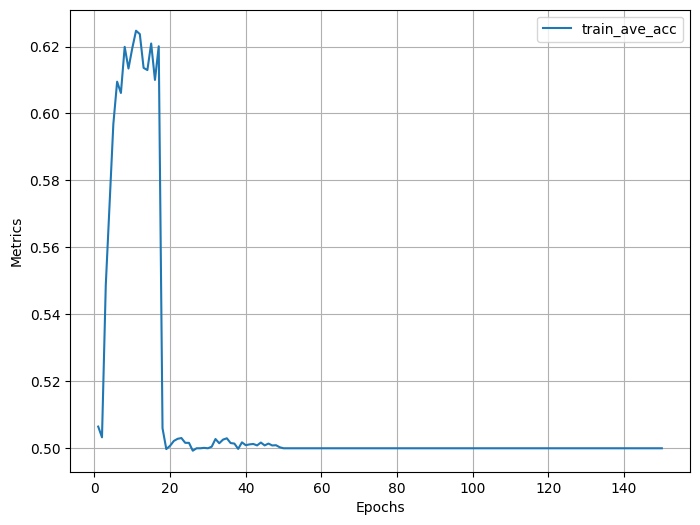

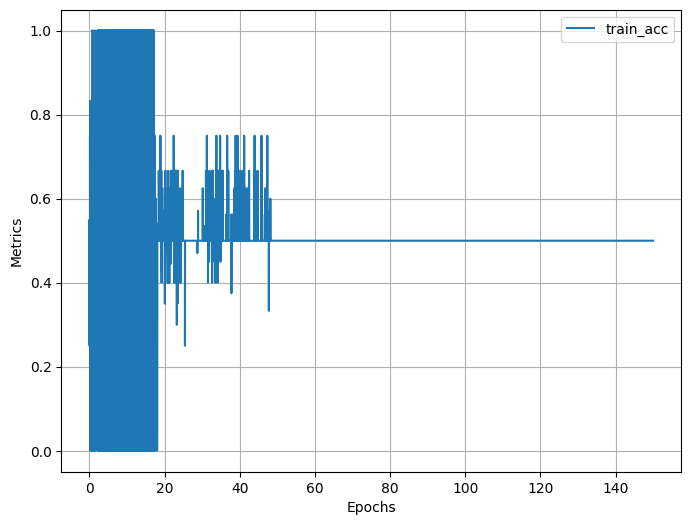

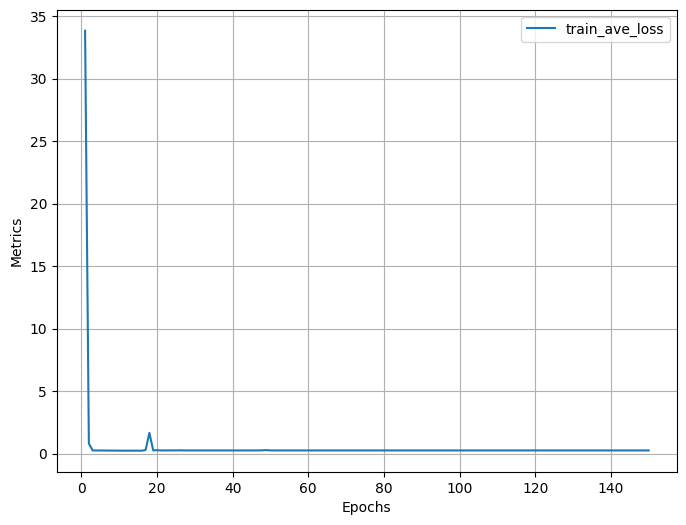

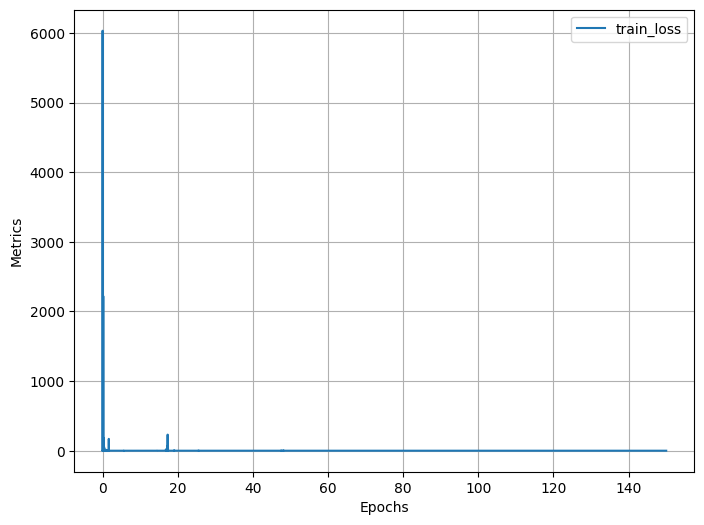

In [4]:
nn_mc_report.plot('train_ave_acc')
nn_mc_report.plot('train_acc')
nn_mc_report.plot('train_ave_loss')
nn_mc_report.plot('train_loss')

#### Evaluation

In [5]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_mc_model.eval()
def nn_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_mc_score, nn_mc_mse = eval.score_model(test_dataset, nn_mc_predict)

def nn_mc_predict_seq(sa_pair_seq):
    pred = nn_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_mc_seq_score, nn_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_mc_predict_seq)

print(f"NN MC Accuracy: {nn_mc_score}")
print(f"NN MC MSE: {nn_mc_mse}")
print(f"NN MC Seq Accuracy: {nn_mc_seq_score}")
print(f"NN MC Seq MSE: {nn_mc_seq_mse}")

NN MC Accuracy: 0.4975062344139651
NN MC MSE: 0.4237981462482245
NN MC Seq Accuracy: 0.49875311720698257
NN MC Seq MSE: 0.250005051018344


### SARSA

#### Training (Without MC Init)

In [6]:
import d_sarsa

nn_sarsa_model, nn_sarsa_report = d_sarsa.train(save=False, use_mc=False)

EPOCH: 1.000  train_ave_loss: 5.183  train_ave_acc: 0.500  (2.76s - 411.10s remaining) ave_loss: 5.1825357059513895 ave_acc: 0.5004737068722638
EPOCH: 2.000  train_ave_loss: 0.133  train_ave_acc: 0.502  (5.71s - 422.40s remaining) ave_loss: 0.13277428059721272 ave_acc: 0.5018974305264629
EPOCH: 3.000  train_ave_loss: 0.124  train_ave_acc: 0.530  (8.61s - 421.68s remaining) ave_loss: 0.12447880837749525 ave_acc: 0.529838809964306
EPOCH: 4.000  train_ave_loss: 0.120  train_ave_acc: 0.537  (11.66s - 425.41s remaining) ave_loss: 0.1203433631965754 ave_acc: 0.5370870743185716
EPOCH: 5.000  train_ave_loss: 0.119  train_ave_acc: 0.544  (14.58s - 422.94s remaining) ave_loss: 0.11939574053778676 ave_acc: 0.54433606248977
EPOCH: 6.000  train_ave_loss: 0.117  train_ave_acc: 0.545  (17.68s - 424.37s remaining) ave_loss: 0.11716367107135983 ave_acc: 0.5446588530269069
EPOCH: 7.000  train_ave_loss: 0.127  train_ave_acc: 0.547  (21.06s - 430.25s remaining) ave_loss: 0.1268871747765723 ave_acc: 0.5473

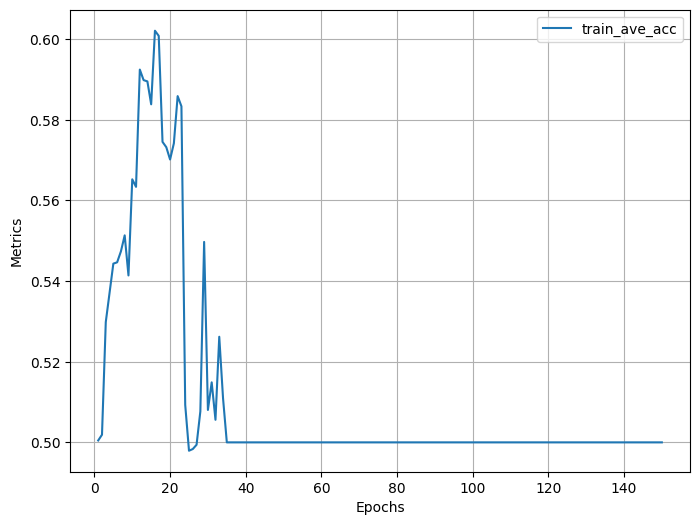

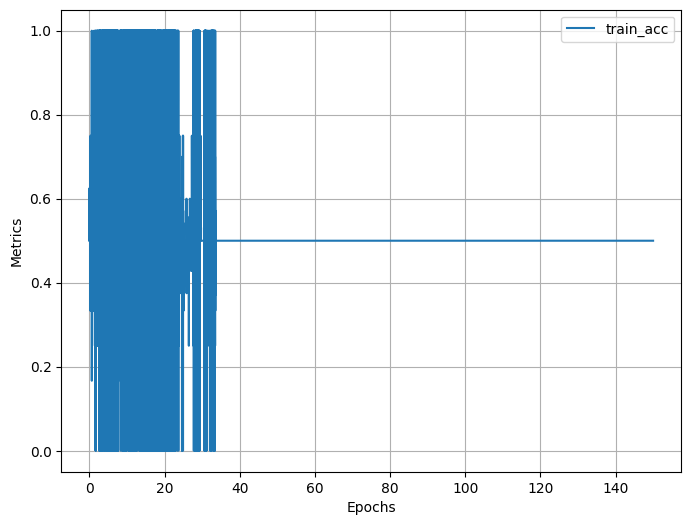

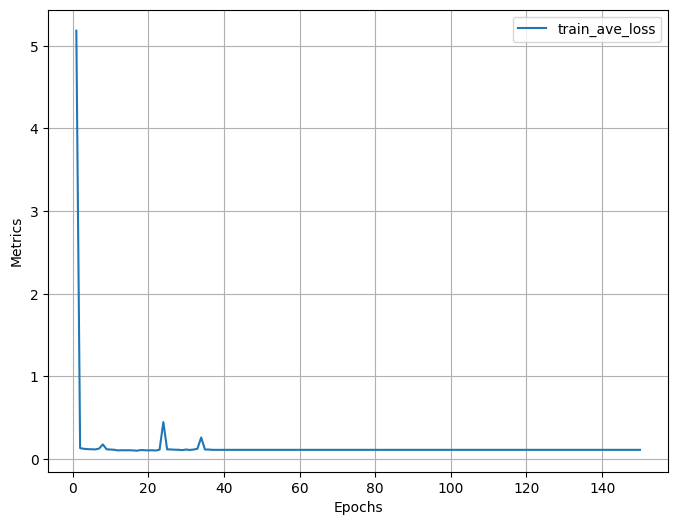

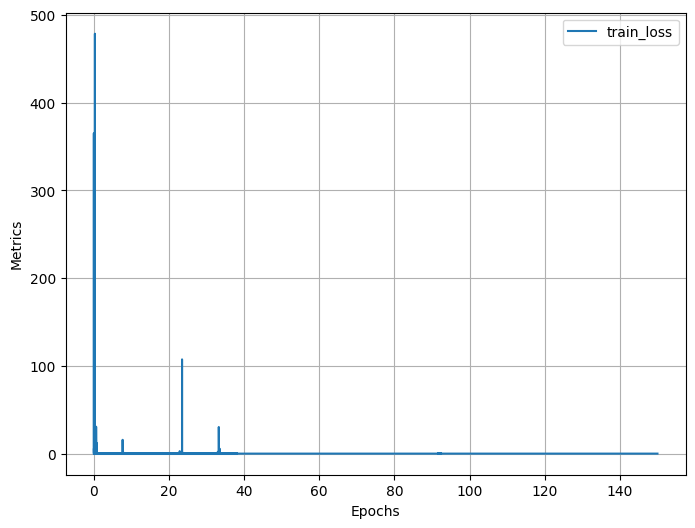

In [7]:
nn_sarsa_report.plot('train_ave_acc')
nn_sarsa_report.plot('train_acc')
nn_sarsa_report.plot('train_ave_loss')
nn_sarsa_report.plot('train_loss')

#### Evaluation (Without MC Init)

In [8]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_model.eval()
def nn_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_score, nn_sarsa_mse = eval.score_model(test_dataset, nn_predict)

def nn_predict_seq(sa_pair_seq):
    pred = nn_sarsa_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_seq_score, nn_sarsa_seq_mse = eval.score_model_sequential(test_dataset, nn_predict_seq)

print(f"NN Sarsa Accuracy: {nn_sarsa_score}")
print(f"NN Sarsa MSE: {nn_sarsa_mse}")
print(f"NN Sarsa Seq Accuracy: {nn_sarsa_seq_score}")
print(f"NN Sarsa Seq MSE: {nn_sarsa_seq_mse}")

NN Sarsa Accuracy: 0.5
NN Sarsa MSE: 0.2499126571569861
NN Sarsa Seq Accuracy: 0.5
NN Sarsa Seq MSE: 0.2500000054450453


#### Training (With MC Init)

In [9]:
import d_sarsa

nn_mc_state_dict = nn_mc_model.state_dict()
nn_sarsa_with_mc_model, nn_sarsa_with_mc_report = d_sarsa.train(save=False, use_mc=False, init_state_dict=nn_mc_state_dict)

Init state dictionary was passed. Using that to initialize model_net.
EPOCH: 1.000  train_ave_loss: 0.112  train_ave_acc: 0.500  (2.60s - 387.55s remaining) ave_loss: 0.11193564831336572 ave_acc: 0.5
EPOCH: 2.000  train_ave_loss: 0.112  train_ave_acc: 0.500  (5.17s - 382.68s remaining) ave_loss: 0.11193520601161501 ave_acc: 0.5
EPOCH: 3.000  train_ave_loss: 0.112  train_ave_acc: 0.500  (7.74s - 379.46s remaining) ave_loss: 0.11193518271899162 ave_acc: 0.5
EPOCH: 4.000  train_ave_loss: 0.112  train_ave_acc: 0.500  (10.31s - 376.35s remaining) ave_loss: 0.11193524713592488 ave_acc: 0.5
EPOCH: 5.000  train_ave_loss: 0.112  train_ave_acc: 0.500  (12.87s - 373.17s remaining) ave_loss: 0.11193525728488292 ave_acc: 0.5
EPOCH: 6.000  train_ave_loss: 0.112  train_ave_acc: 0.500  (15.43s - 370.26s remaining) ave_loss: 0.11193529853892248 ave_acc: 0.5
EPOCH: 7.000  train_ave_loss: 0.112  train_ave_acc: 0.500  (18.01s - 367.91s remaining) ave_loss: 0.11193634324524104 ave_acc: 0.5
EPOCH: 8.000  tr

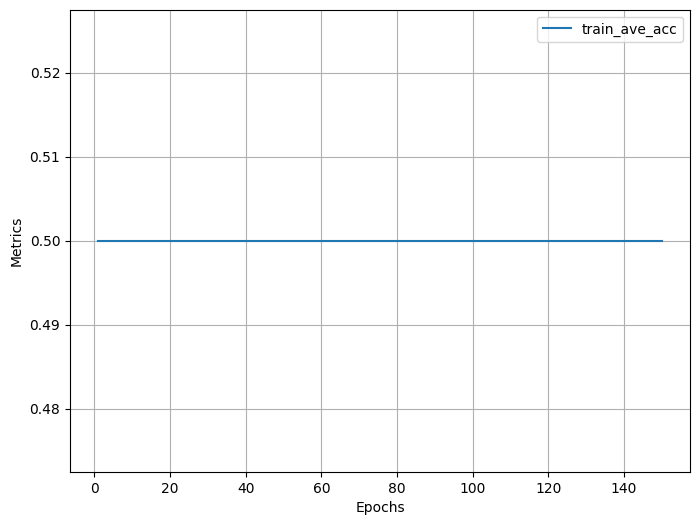

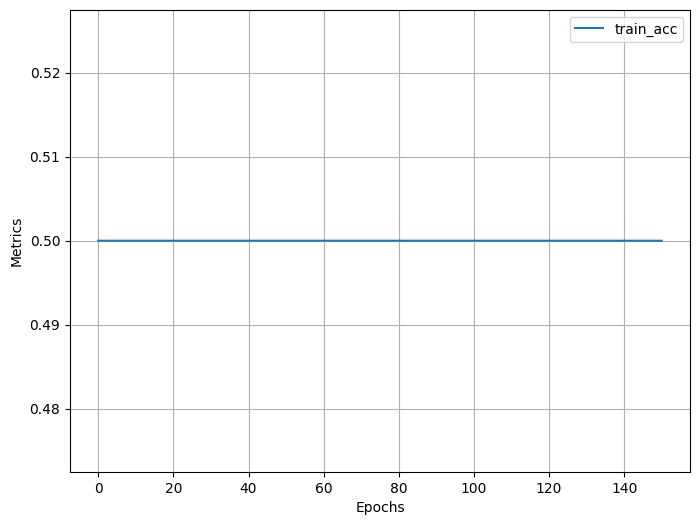

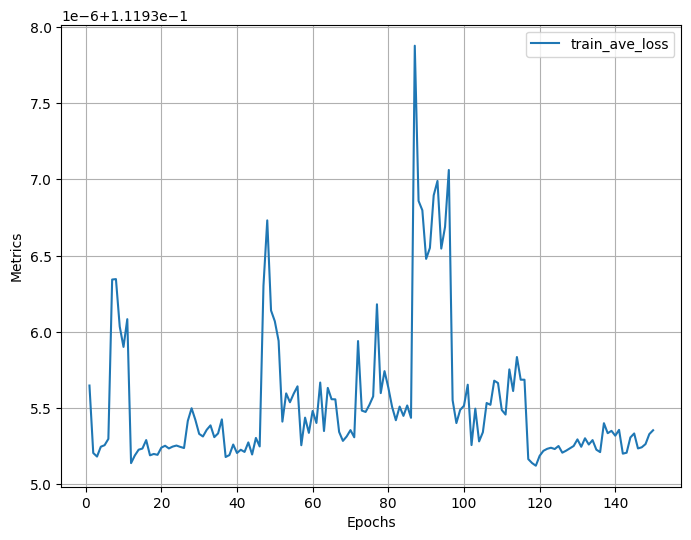

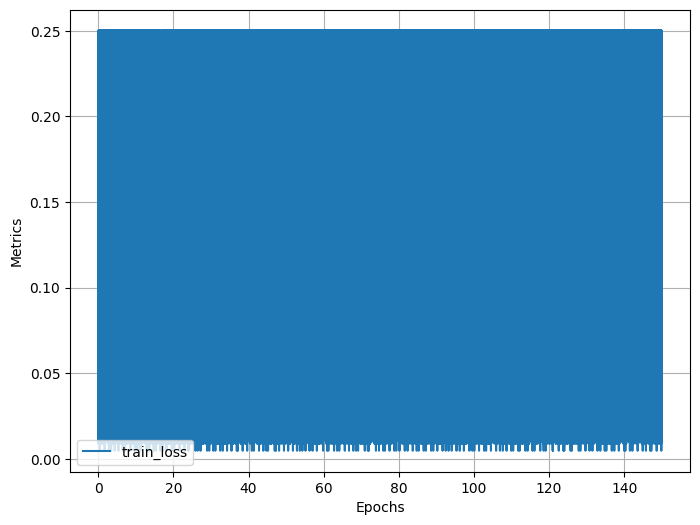

In [10]:
nn_sarsa_with_mc_report.plot('train_ave_acc')
nn_sarsa_with_mc_report.plot('train_acc')
nn_sarsa_with_mc_report.plot('train_ave_loss')
nn_sarsa_with_mc_report.plot('train_loss')

#### Evaluation (With MC Init)

In [11]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_with_mc_model.eval()
def nn_sarsa_with_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_with_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_with_mc_score, nn_sarsa_with_mc_mse = eval.score_model(test_dataset, nn_sarsa_with_mc_predict)

def nn_sarsa_with_mc_predict_seq(sa_pair_seq):
    pred = nn_sarsa_with_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_with_mc_seq_score, nn_sarsa_with_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_sarsa_with_mc_predict_seq)

print(f"NN Sarsa With MC Init Accuracy: {nn_sarsa_with_mc_score}")
print(f"NN Sarsa With MC Init MSE: {nn_sarsa_with_mc_mse}")
print(f"NN Sarsa With MC Init Seq Accuracy: {nn_sarsa_with_mc_seq_score}")
print(f"NN Sarsa With MC Init Seq MSE: {nn_sarsa_with_mc_seq_mse}")

NN Sarsa With MC Init Accuracy: 0.5012468827930174
NN Sarsa With MC Init MSE: 0.42378713898736275
NN Sarsa With MC Init Seq Accuracy: 0.5
NN Sarsa With MC Init Seq MSE: 0.2500051206643794


In [12]:
import os

model_dirpath = 'experiment_models/150epoch_e-2lr_vanilla_paper_params'
os.makedirs(model_dirpath, exist_ok=True)


torch.save(nn_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_mc_model.pth'))
torch.save(nn_sarsa_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_model.pth'))
torch.save(nn_sarsa_with_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_with_mc_model.pth'))

## Conclusion

### Summary

### Future extensions